In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
plan = "train_test_split, scale, generator, model, test_predictions, forecast"

In [44]:
df = pd.read_csv('C:\\Users\\Ufuk Altan\\Downloads\\Downloads\\Data Science\\DATA\\Frozen_Dessert_Production.csv')
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [45]:
df = pd.read_csv('C:\\Users\\Ufuk Altan\\Downloads\\Downloads\\Data Science\\DATA\\Frozen_Dessert_Production.csv', parse_dates=True,index_col='DATE')
df.columns=['Production']
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [46]:
len(df)

573

In [47]:
def train_and_test(test_size, dataframe):
    test_index = len(dataframe) - test_size
    train_data = dataframe.iloc[:test_index]
    test_data = dataframe.iloc[test_index:]
    return train_data, test_data


In [48]:
train,test = train_and_test(24,df)

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [51]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [52]:
#GENERATOR

length = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length, batch_size=1)

val_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [54]:
model = Sequential()

model.add(LSTM(100,activation='relu', input_shape = (length,n_features)))

model.add(Dense(1))

model.compile(loss='mse', optimizer ='adam')

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

In [56]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit_generator(generator, validation_data=val_generator,epochs=15,callbacks=[early_stop])

Epoch 1/15
537/537 [==============================] - 37s 70ms/step - loss: 0.0225 - val_loss: 0.0032
Epoch 2/15
537/537 [==============================] - 40s 74ms/step - loss: 0.0089 - val_loss: 0.0023
Epoch 3/15
537/537 [==============================] - 39s 72ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 4/15
537/537 [==============================] - 39s 72ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 5/15
537/537 [==============================] - 39s 73ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 6/15
537/537 [==============================] - 36s 66ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 7/15
537/537 [==============================] - 36s 68ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 8/15
537/537 [==============================] - 35s 66ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 9/15
537/537 [==============================] - 37s 68ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 10/15
537/537 [==============================] - 35s 64ms/step - loss: 0.003

In [59]:
losses = pd.DataFrame(model.history.history)

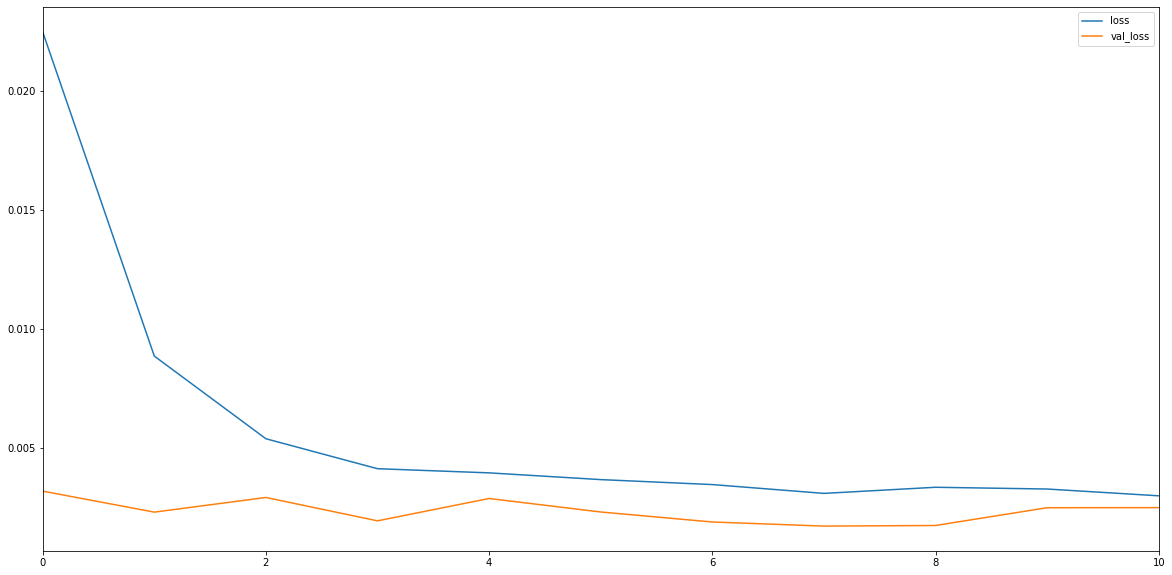

In [60]:
losses.plot(figsize=(20,10))

In [87]:
def create_predictions(test_data, model = model):
    test_predictions = []
    
    if type(test_data) == "pandas.core.frame.DataFrame":
        test_period = len(test_data)
    else:
        test_period = test_data
        
    
    global length, n_features

    first_evaluation_batch = scaled_train[-length:]
    current_batch = first_evaluation_batch.reshape((1,length,n_features))

    for i in range(test_period):

        current_pred = model.predict(current_batch)[0]

        test_predictions.append(current_pred)

        current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis =1)

    predictions = scaler.inverse_transform(test_predictions)

    return predictions

In [84]:
type(periods)

int

In [62]:
predictions = create_predictions(test)

In [63]:
test['Predictions'] = predictions

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


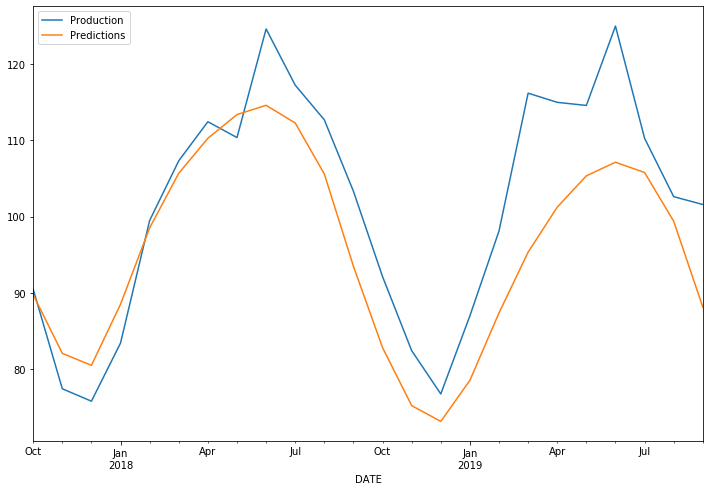

In [65]:
test.plot(figsize=(12,8))

In [66]:
def percentage_error(dataframe,pred, true_value):
    
    '''
    dataframe: Pass in pandas dataframe variable
    pred = dataframe['Predictions'] #model.predict(x_test).reshape()
    true_value = dataframe['True Values'] #y_test
    
    '''
    
    difference = true_value - pred
    
    dataframe['Error(%)']= np.absolute(difference/true_value*100)
    
    print('Average Percentage Error is: {}'.format(dataframe['Error(%)'].mean()))

In [67]:
percentage_error(test, test['Predictions'], test['Production'])

Average Percentage Error is: 7.129815011942742


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [68]:
test.describe()

,Production,Predictions,Error(%)
count,24.000000,24.000000,24.000000
mean,101.504292,95.587400,7.129815
std,15.196702,12.769700,4.510030
min,75.811800,73.159645,0.784448
25%,89.604600,86.240089,3.837863
50%,102.960150,96.931617,6.246600
75%,113.148750,105.703280,9.812271
max,124.960500,114.582939,17.933458


In [72]:
#FORECAST
full_scaler = MinMaxScaler()
data = full_scaler.fit_transform(df)

In [70]:
plan

'train_test_split, scale, generator, model, test_predictions, forecast'

In [73]:
length = 12 

generator = TimeseriesGenerator(data,data, length = length, batch_size=1)

In [75]:
modelForecast = Sequential()

modelForecast.add(LSTM(100, activation='relu', input_shape=(length,n_features)))

modelForecast.add(Dense(1))

modelForecast.compile(loss='mse', optimizer = 'adam')

In [76]:
modelForecast.fit_generator(generator,epochs=10 )

Epoch 1/10
561/561 [==============================] - 41s 74ms/step - loss: 0.0214
Epoch 2/10
561/561 [==============================] - 39s 69ms/step - loss: 0.0090
Epoch 3/10
561/561 [==============================] - 42s 75ms/step - loss: 0.0052
Epoch 4/10
561/561 [==============================] - 38s 67ms/step - loss: 0.0053
Epoch 5/10
561/561 [==============================] - 39s 70ms/step - loss: 0.0045
Epoch 6/10
561/561 [==============================] - 36s 63ms/step - loss: 0.0043
Epoch 7/10
561/561 [==============================] - 36s 65ms/step - loss: 0.0039
Epoch 8/10
561/561 [==============================] - 36s 64ms/step - loss: 0.0035
Epoch 9/10
561/561 [==============================] - 39s 69ms/step - loss: 0.0036
Epoch 10/10
561/561 [==============================] - 40s 71ms/step - loss: 0.0033


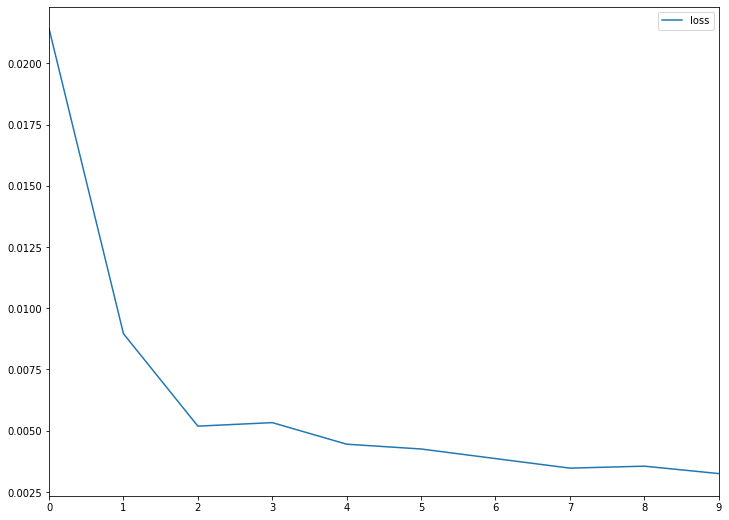

In [78]:
loss = pd.DataFrame(modelForecast.history.history)
loss.plot(figsize=(12,9))

In [88]:
periods = 12
forecast = create_predictions(periods, model=modelForecast)

In [90]:
df

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
1972-06-01,100.5960
1972-07-01,100.1263
1972-08-01,96.3607
1972-09-01,85.8007


In [91]:
forecast_index = pd.date_range(start='2019-10-01',periods=periods, freq='MS')

In [92]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [93]:
forecasts = pd.DataFrame(data = forecast, index=forecast_index, columns=['Forecast'])

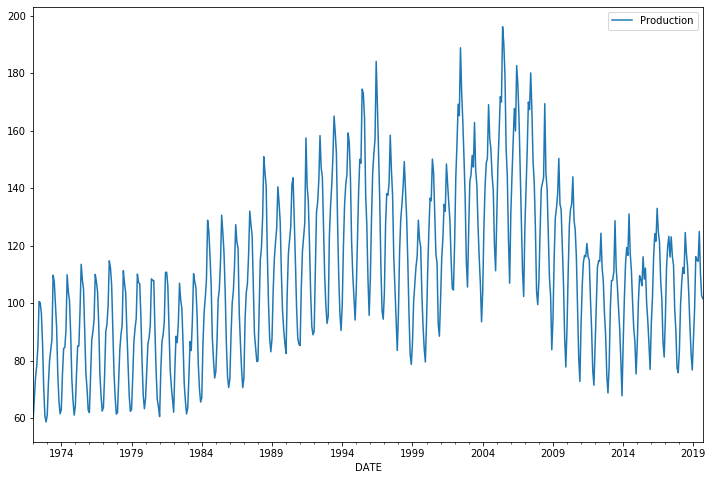

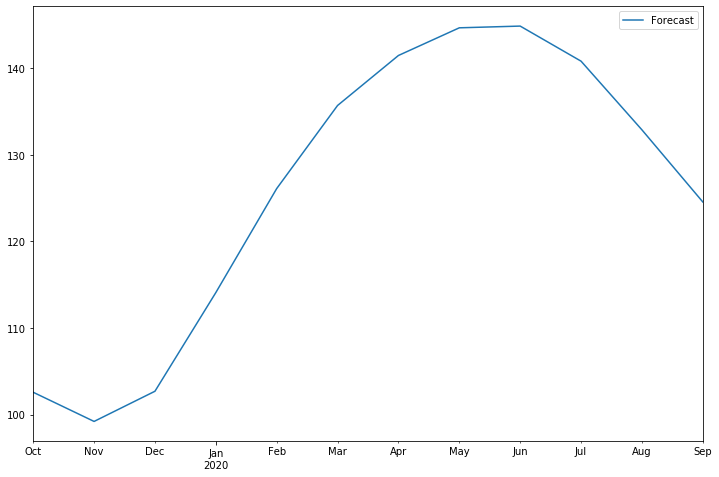

In [94]:
df.plot(figsize=(12,8))
forecasts.plot(figsize=(12,8))

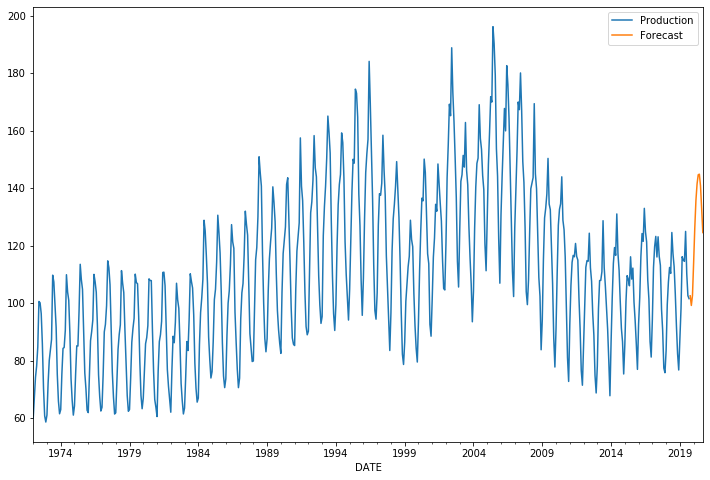

In [100]:
ax = df.plot()
forecasts.plot(ax=ax,figsize=(12,8))

(564, 609)

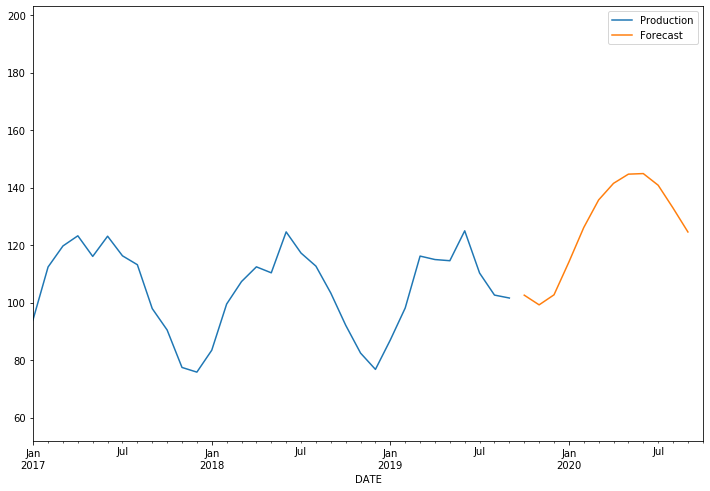

In [104]:
ax = df.plot()
forecasts.plot(ax=ax,figsize=(12,8))
plt.xlim('2017-01-01','2020-10-01')

In [101]:
forecasts

,Forecast
2019-10-01,102.579873
2019-11-01,99.211194
2019-12-01,102.696861
2020-01-01,114.092151
2020-02-01,126.105209
2020-03-01,135.701837
2020-04-01,141.477101
2020-05-01,144.672715
2020-06-01,144.872119
2020-07-01,140.820351


In [105]:
from sklearn.metrics import mean_squared_error
from numpy import sqrt

In [106]:
test

,Production,Predictions,Error(%)
DATE,,,
2017-10-01,90.4732,89.763485,0.784448
2017-11-01,77.4378,82.078269,5.992511
2017-12-01,75.8118,80.507926,6.194452
2018-01-01,83.4343,88.518499,6.093656
2018-02-01,99.4899,98.525056,0.969791
2018-03-01,107.3152,105.680141,1.523604
2018-04-01,112.4309,110.263040,1.928171
2018-05-01,110.3544,113.366055,2.729075
2018-06-01,124.5841,114.582939,8.027638


In [108]:
np.sqrt(mean_squared_error(test['Production'], test['Predictions']))

8.977192468520018